In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


In [ ]:
class RBFNet(nn.Module):
    def __init__(self, input_dim, sigma=1.0):
        super(RBFNet, self).__init__()
        self.input_dim = input_dim
        self.centers = nn.ParameterList([])  # Use ParameterList for dynamic centers
        self.sigma = sigma  # Fixed sigma for simplicity in this iterative OLS context

        # The linear layer will be initialized dynamically
        self.linear_layer = None
        self.num_rbfs = 0  # Track current number of RBFs

    def add_rbf_center(self, new_center, w=1):
        """Adds a new RBF center to the network."""
        new_center_param = nn.Parameter(new_center.clone().detach())
        self.centers.append(new_center_param)
        self.num_rbfs += 1
        # Re-initialize the linear layer as its input size changes
        # Its weights will be determined by OLS after all centers are selected.
        # We need to re-create it to reflect the new input_features (num_rbfs)

        current_weights = self.linear_layer.weight.data if self.linear_layer else None
        self.linear_layer = nn.Linear(self.num_rbfs, 1, bias=False)
        if current_weights is not None:
            # If the linear layer already exists, copy the weights to the new layer
            self.linear_layer.weight.data[:, : current_weights.shape[1]] = (
                current_weights
            )
        # Set the currently added center's weight
        self.linear_layer.weight.data[:, self.num_rbfs - 1] = torch.tensor(w)
        # Ensure the new linear layer is on the correct device if already moved
        if self.centers and self.centers[0].is_cuda:
            self.linear_layer.to(self.centers[0].device)

    def _rbf_gaussian(self, x, center, sigma):
        # x: (batch_size, input_dim)
        # center: (input_dim,)
        # sigma: scalar
        diff = x - center
        dist_sq = torch.sum(diff**2, dim=1)
        sigma_sq = sigma**2 + 1e-8  # Add epsilon for stability
        return torch.exp(-dist_sq / (2 * sigma_sq))

    def forward(self, x):
        if self.num_rbfs == 0:
            # If no RBFs are selected yet, return zeros (or raise error based on desired behavior)
            return torch.zeros(x.size(0), 1, device=x.device)

        batch_size = x.size(0)
        rbf_activations = torch.empty(batch_size, self.num_rbfs, device=x.device)

        # Parallel computation of RBF activations for all centers
        centers_stack = torch.stack(
            [center for center in self.centers]
        )  # (num_rbfs, input_dim)
        # x: (batch_size, input_dim), centers_stack: (num_rbfs, input_dim)
        # Compute (x - c)^2 for all x and all centers
        # Expand x to (batch_size, 1, input_dim), centers_stack to (1, num_rbfs, input_dim)
        diff = x.unsqueeze(1) - centers_stack.unsqueeze(
            0
        )  # (batch_size, num_rbfs, input_dim)
        dist_sq = torch.sum(diff**2, dim=2)  # (batch_size, num_rbfs)
        sigma_sq = self.sigma**2 + 1e-8
        rbf_activations = torch.exp(-dist_sq / (2 * sigma_sq))

        # Pass RBF activations through the linear output layer
        output = self.linear_layer(rbf_activations)
        return output


In [ ]:
def train_rbf_iterative_ols_err(
    model, X_train, y_train, max_rbfs=50, min_residual_error=1e-3
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    model.to(device)

    # Candidate centers are all training data points
    candidate_centers = X_train.clone().detach()
    candidate_indices = list(
        range(candidate_centers.size(0))
    )  # Pool of unselected indices

    # Initial residual is the target itself
    current_residual = y_train.clone().view(-1, 1)

    print(
        f"Starting iterative OLS RBF network construction (max_rbfs={max_rbfs}, min_residual_error={min_residual_error})"
    )

    for k in range(max_rbfs):
        best_candidate_idx_in_pool = -1
        max_err_reduction = -float("inf")  # We want to maximize this

        # Iterate through all available candidate centers in the pool
        for pool_idx, global_idx in enumerate(candidate_indices):
            candidate_center = candidate_centers[global_idx]

            # Calculate RBF activation for this candidate center
            with torch.no_grad():
                # phi_j for the current candidate
                phi_j = model._rbf_gaussian(X_train, candidate_center, model.sigma)
                phi_j = phi_j.view(-1, 1)  # Ensure column vector

            # Calculate Error Reduction Ratio (ERR) for this candidate
            # ERR_j = (phi_j^T * current_residual)^2 / (phi_j^T * phi_j)
            numerator = torch.dot(phi_j.squeeze(), current_residual.squeeze()) ** 2
            denominator = torch.dot(phi_j.squeeze(), phi_j.squeeze())  # phi_j^T * phi_j

            # Avoid division by zero if phi_j is all zeros (highly unlikely with Gaussian)
            if denominator.item() < 1e-12:
                err_j = 0.0
            else:
                err_j = numerator / denominator

            if err_j > max_err_reduction:
                max_err_reduction = err_j
                best_candidate_idx_in_pool = (
                    pool_idx  # Store index within the candidate_indices list
                )

        if (
            best_candidate_idx_in_pool == -1 or max_err_reduction <= 1e-9
        ):  # If no significant reduction
            print(
                "No suitable candidate found to significantly reduce error. Terminating."
            )
            break

        # Get the global index of the selected center
        selected_global_idx = candidate_indices[best_candidate_idx_in_pool]

        # Add the best candidate center to the model
        model.add_rbf_center(candidate_centers[selected_global_idx])
        print(
            f"Added RBF center {k+1}/{max_rbfs} (candidate index {selected_global_idx}). Max ERR: {max_err_reduction.item():.6f}"
        )

        # Remove the selected center from the pool of candidates
        candidate_indices.pop(best_candidate_idx_in_pool)

        current_residual -= max_err_reduction

        # Calculate current model predictions and update the residual
        model.eval()
        with torch.no_grad():
            current_predictions = model(X_train)
            current_mse = torch.mean((current_predictions - y_train) ** 2).item()
            # Update the residual for the next iteration based on the *current model's predictions*
            current_residual = y_train.view(-1, 1) - current_predictions

            print(f"  Current MSE of model: {current_mse:.6f}")

        if current_mse < min_residual_error:
            print(
                f"Residual error ({current_mse:.6f}) below threshold ({min_residual_error}). Terminating."
            )
            break

    print("\nIterative OLS RBF network construction complete.")
    model.train()  # Set back to train mode
    return model


In [ ]:
# --- Generate Synthetic Time Series Data ---
def synthetic_time_series(num_samples=200):
    """Generate a 1D time series"""
    t = torch.linspace(0, 4 * torch.pi, num_samples)
    # Create a more complex time series
    y = (
        torch.sin(t)
        + 0.5 * torch.cos(3 * t)
        + 0.3 * torch.sin(5 * t)
        + torch.randn(num_samples) * 0.1
    )
    return y


In [ ]:
def create_delay_embedding(time_series, embedding_dim=5, delay=1):
    """
    Create delay embedded vectors from a time series.

    Parameters:
    - time_series: 1D tensor of shape (T,) where T is the length of time series
    - embedding_dim: Number of delay coordinates (dimension of embedded vectors)
    - delay: Time delay between coordinates

    Returns:
    - X: Input vectors of shape (N, embedding_dim) where N = T - (embedding_dim-1)*delay
    - y: Target values of shape (N,) - next values to predict
    """
    T = len(time_series)
    max_delay = (embedding_dim - 1) * delay

    if T <= max_delay + 1:  # +1 because we need one more sample for the offset target
        raise ValueError(
            f"Time series too short. Need at least {max_delay + 2} samples."
        )

    N = T - max_delay
    X = torch.zeros(N, embedding_dim)

    # Create delay embedded vectors
    for i in range(N):
        for j in range(embedding_dim):
            X[i, j] = time_series[i + j * delay]

    # Target is the NEXT value after the embedding window (t+1 prediction)
    # This prevents data leakage where the target would be the same as the last input
    y = time_series[max_delay + 1 :].clone()

    # Adjust N to account for the offset target
    N = N - 1
    X = X[:N]  # Remove the last input vector since it has no corresponding target

    return X, y


In [ ]:
def synthetic_data_for_range_embedded(
    t_start, t_end, num_samples=200, embedding_dim=5, delay=1
):
    """Generate delay embedded data for a specific time range"""
    t = torch.linspace(t_start, t_end, num_samples)
    # Create a more complex time series

    time_series = (
        torch.sin(t)
        + 0.5 * torch.cos(3 * t)
        + 0.3 * torch.sin(5 * t)
        + torch.randn(num_samples) * 0.1
    )

    X, y = create_delay_embedding(time_series, embedding_dim, delay)
    return X, y.unsqueeze(1)  # Add dimension to y for consistency


In [ ]:
def train_rbf_iterative_ols_custom(
    model,
    X_train,
    y_train,
    max_rbfs=50,
    residual_threshold=0.01,
    candidate_centers=None,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train = X_train.to(device)
    y_train = y_train.to(device).squeeze()
    model.to(device)

    if candidate_centers is None:
        candidate_centers = X_train.clone().detach()
        candidate_indices = list(
            range(candidate_centers.size(0))
        )  # Pool of unselected indices

    phi_matrix = torch.zeros(X_train.size(0), candidate_centers.size(0), device=device)

    for i in range(phi_matrix.size(1)):
        phi_matrix[:, i] = model._rbf_gaussian(
            X_train, candidate_centers[i], model.sigma
        )

    candidate_indices = list(range(candidate_centers.size(0)))

    residuals = y_train.clone().detach()

    for k in range(max_rbfs):

        if len(candidate_indices) == 0:
            print("No more candidate centers available.")
            break

        j_star = -1
        min_remaining_residuals = float("inf")
        w_j_star = None

        for j in candidate_indices:
            w_j = (torch.dot(phi_matrix[:, j], residuals)) / torch.sum(
                phi_matrix[:, j] ** 2
            )

            remaining_residuals = torch.sum((residuals - phi_matrix[:, j] * w_j) ** 2)

            if remaining_residuals < min_remaining_residuals:
                min_remaining_residuals = remaining_residuals
                j_star = j
                w_j_star = w_j

        print(f"Iteration {k+1}:")
        print(f"\tSelected center index {j_star}")
        print(f"\tMin remaining residuals: {min_remaining_residuals:.4f}")
        print(f"\tWeight for center {j_star}: {w_j_star.item():.4f}")
        print(
            f"\tRemaining residuals: {torch.sum((residuals - phi_matrix[:, j_star] * w_j_star)**2).item():.4f}"
        )

        if j_star == -1 or min_remaining_residuals < residual_threshold:
            print("No significant reduction in residuals. Stopping.")
            break

        model.add_rbf_center(candidate_centers[j_star], w_j_star)
        candidate_indices.remove(j_star)

        # Update the phi matrix with the new center
        for i in candidate_indices:
            b_i = torch.dot(phi_matrix[:, i], phi_matrix[:, j_star]) / torch.sum(
                phi_matrix[:, j_star] ** 2
            )

            phi_matrix[:, i] -= b_i * phi_matrix[:, j_star]

        residuals -= phi_matrix[:, j_star] * w_j_star

        if torch.mean(residuals**2).item() < residual_threshold:
            print(f"Residuals below threshold {residual_threshold}. Stopping training.")
            break

    return model


In [ ]:
# --- Delay Embedding Parameters ---
embedding_dim = 5  # Number of delay coordinates
delay = 1  # Time delay between coordinates
# Generate training data on a limited time range for extrapolation testing
X_train, y_train = synthetic_data_for_range_embedded(
    0, 2 * torch.pi, num_samples=150, embedding_dim=embedding_dim, delay=delay
)

# Generate test data for extrapolation (future time steps), continuous with training
X_test, y_test = synthetic_data_for_range_embedded(
    2 * torch.pi,
    3 * torch.pi,
    num_samples=80 + embedding_dim * delay,
    embedding_dim=embedding_dim,
    delay=delay,
)
# Remove the first (embedding_dim * delay) samples from X_test and y_test to ensure continuity
X_test = X_test[embedding_dim * delay :]
y_test = y_test[embedding_dim * delay :]

# Also create full range data for visualization
X_full, y_full = synthetic_data_for_range_embedded(
    0, 3 * torch.pi, num_samples=250, embedding_dim=embedding_dim, delay=delay
)

print(f"Training data shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test data shape: X_test {X_test.shape}, y_test {y_test.shape}")
print(f"Full data shape: X_full {X_full.shape}, y_full {y_full.shape}")
print(f"Embedding dimension: {embedding_dim}, Delay: {delay}")

# --- Hyperparameters for iterative OLS ---
input_dim = X_train.size(1)  # Now this will be the embedding dimension
fixed_sigma = 1.0  # Sigma is fixed for all RBFs in this iterative approach
max_rbfs_to_build = 30  # Maximum number of RBFs to add
target_residual_mse = 0.005  # Stop when MSE drops below this

print(f"Input dimension (embedding_dim): {input_dim}")

# --- Initialize RBF Network (starts empty) ---
rbf_net_iterative = RBFNet(input_dim=input_dim, sigma=fixed_sigma)

# --- Train with Iterative OLS (Error Reduction Ratio based) ---
rbf_net_iterative = train_rbf_iterative_ols_custom(
    rbf_net_iterative,
    X_train,
    y_train,
    max_rbfs=max_rbfs_to_build,
    residual_threshold=target_residual_mse,
)


Training data shape: X_train torch.Size([145, 5]), y_train torch.Size([145, 1])
Test data shape: X_test torch.Size([75, 5]), y_test torch.Size([75, 1])
Full data shape: X_full torch.Size([245, 5]), y_full torch.Size([245, 1])
Embedding dimension: 5, Delay: 1
Input dimension (embedding_dim): 5
Iteration 1:
	Selected center index 109
	Min remaining residuals: 54.4789
	Weight for center 109: -1.3501
	Remaining residuals: 54.4789
Iteration 2:
	Selected center index 33
	Min remaining residuals: 8.3597
	Weight for center 33: 1.3830
	Remaining residuals: 8.3597
Iteration 3:
	Selected center index 123
	Min remaining residuals: 7.7787
	Weight for center 123: 1.4313
	Remaining residuals: 7.7787


C:\Users\User\AppData\Local\Temp\ipykernel_91304\2250481884.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.linear_layer.weight.data[:, self.num_rbfs - 1] = torch.tensor(w)


Iteration 4:
	Selected center index 70
	Min remaining residuals: 7.3124
	Weight for center 70: -0.1561
	Remaining residuals: 7.3124
Iteration 5:
	Selected center index 140
	Min remaining residuals: 5.3074
	Weight for center 140: 0.9412
	Remaining residuals: 5.3074
Iteration 6:
	Selected center index 37
	Min remaining residuals: 4.8166
	Weight for center 37: 0.7730
	Remaining residuals: 4.8166
Iteration 7:
	Selected center index 31
	Min remaining residuals: 3.4546
	Weight for center 31: 1.9044
	Remaining residuals: 3.4546
Iteration 8:
	Selected center index 112
	Min remaining residuals: 3.0621
	Weight for center 112: -0.6937
	Remaining residuals: 3.0621
Iteration 9:
	Selected center index 138
	Min remaining residuals: 2.9706
	Weight for center 138: -0.3674
	Remaining residuals: 2.9706
Iteration 10:
	Selected center index 49
	Min remaining residuals: 2.8745
	Weight for center 49: -0.5074
	Remaining residuals: 2.8745
Iteration 11:
	Selected center index 34
	Min remaining residuals: 2.7529

In [ ]:
# --- Evaluate the Model ---
rbf_net_iterative.eval()
with torch.no_grad():
    # Evaluate on training data
    train_predictions = rbf_net_iterative(X_train)
    train_mse = torch.mean((train_predictions - y_train) ** 2)
    print(f"\nTraining MSE: {train_mse.item():.4f}")

    # Evaluate on extrapolation test data
    test_predictions = rbf_net_iterative(X_test)
    test_mse = torch.mean((test_predictions - y_test) ** 2)
    print(f"Extrapolation Test MSE: {test_mse.item():.4f}")

    # Get predictions for full range for visualization
    full_predictions = rbf_net_iterative(X_full)

    print(f"Total RBFs in final model: {rbf_net_iterative.num_rbfs}")



Training MSE: 89.8074
Extrapolation Test MSE: 60.7388
Total RBFs in final model: 30


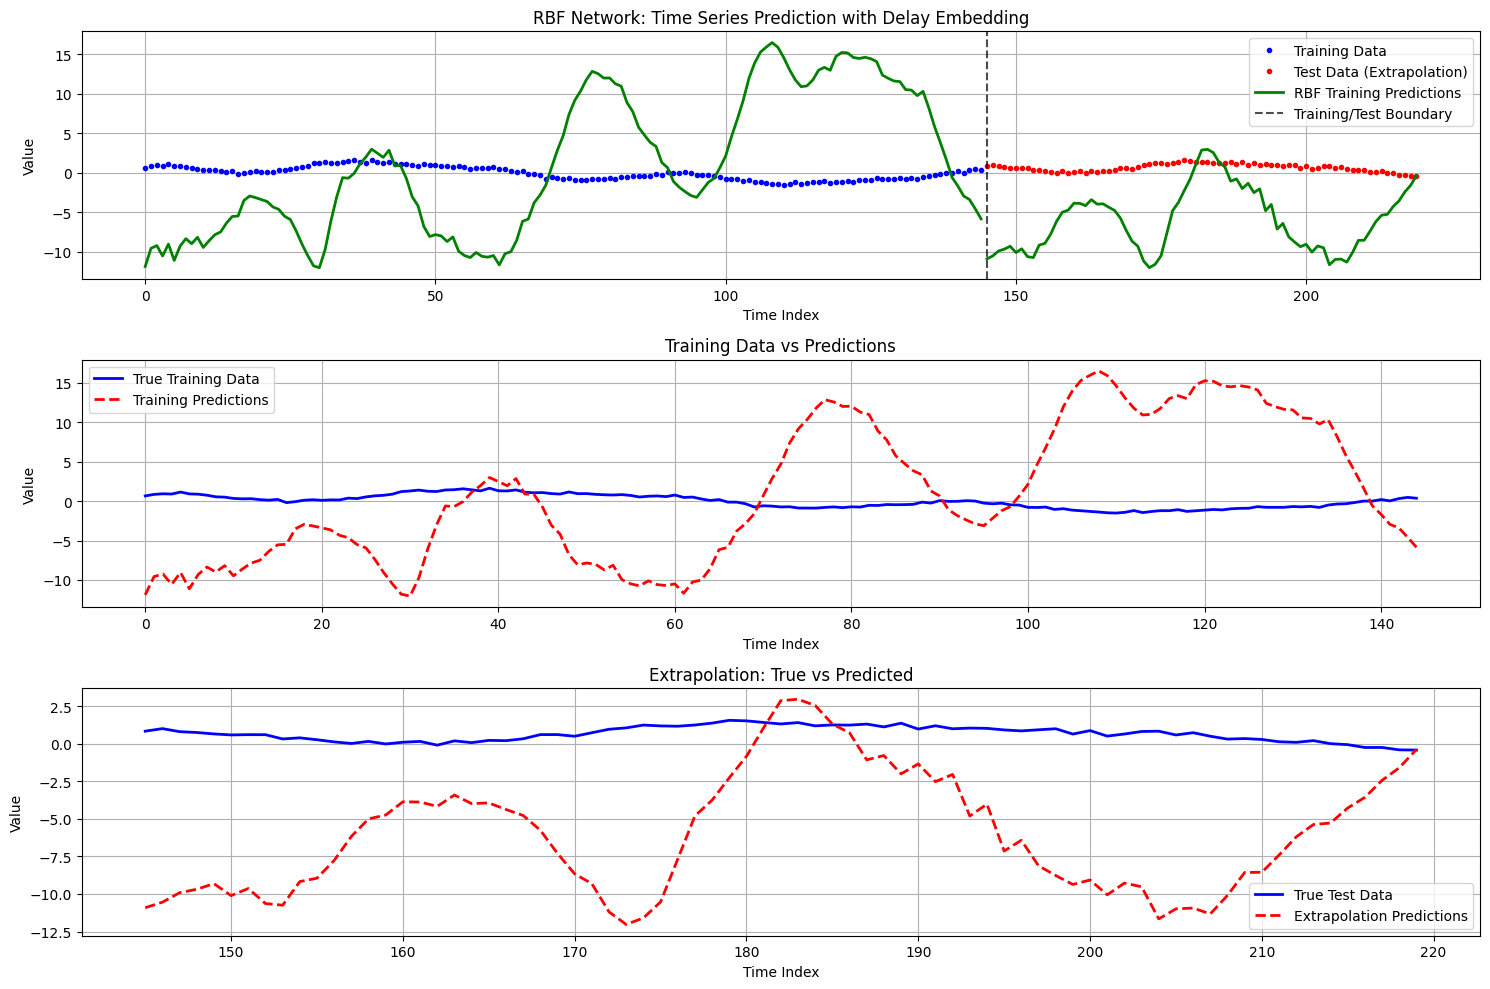

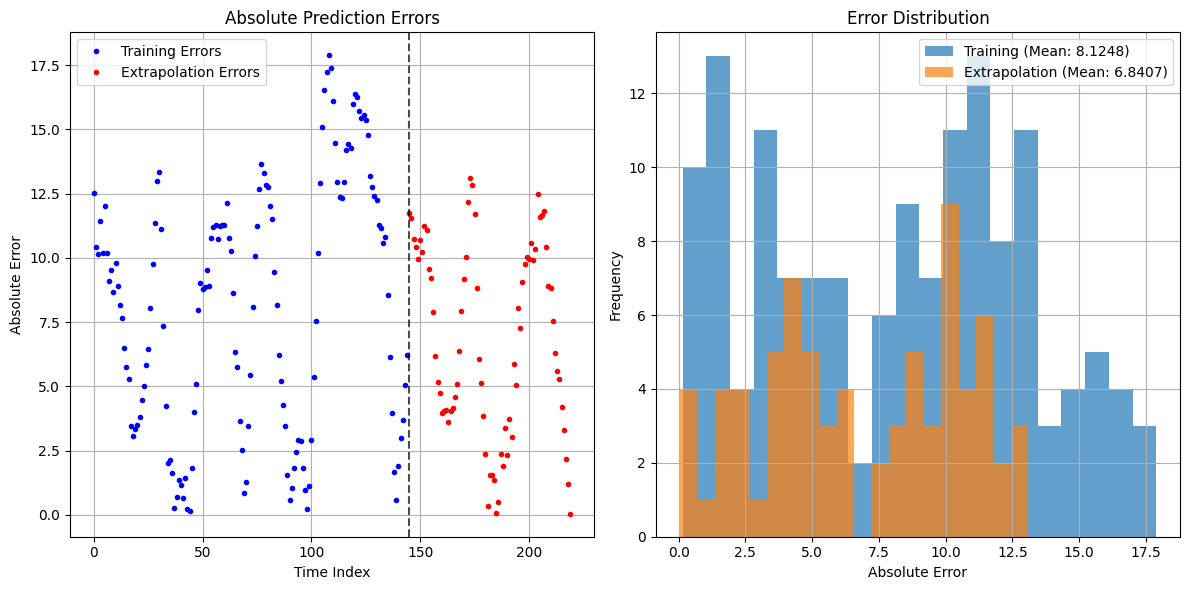

In [ ]:
# --- Plotting Results ---
import matplotlib.pyplot as plt

# Create time indices for plotting
train_time_idx = torch.arange(len(y_train))
test_time_idx = torch.arange(len(y_train), len(y_train) + len(y_test))
full_time_idx = torch.arange(len(y_full))

plt.figure(figsize=(15, 10))

# Plot time series predictions
plt.subplot(3, 1, 1)
plt.plot(
    train_time_idx.cpu().numpy(),
    y_train.cpu().numpy(),
    "bo",
    label="Training Data",
    markersize=3,
)
plt.plot(
    test_time_idx.cpu().numpy(),
    y_test.cpu().numpy(),
    "ro",
    label="Test Data (Extrapolation)",
    markersize=3,
)
# Plot training predictions
plt.plot(
    train_time_idx.cpu().numpy(),
    train_predictions.cpu().numpy(),
    "g-",
    label="RBF Training Predictions",
    linewidth=2,
)
# Plot test predictions
plt.plot(
    test_time_idx.cpu().numpy(),
    test_predictions.cpu().numpy(),
    "g-",
    linewidth=2,
)
plt.axvline(
    x=len(y_train), color="k", linestyle="--", alpha=0.7, label="Training/Test Boundary"
)
plt.title("RBF Network: Time Series Prediction with Delay Embedding")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# Plot training vs prediction comparison
plt.subplot(3, 1, 2)
plt.plot(
    train_time_idx.cpu().numpy(),
    y_train.cpu().numpy(),
    "b-",
    label="True Training Data",
    linewidth=2,
)
plt.plot(
    train_time_idx.cpu().numpy(),
    train_predictions.cpu().numpy(),
    "r--",
    label="Training Predictions",
    linewidth=2,
)
plt.title("Training Data vs Predictions")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# Plot extrapolation comparison
plt.subplot(3, 1, 3)
plt.plot(
    test_time_idx.cpu().numpy(),
    y_test.cpu().numpy(),
    "b-",
    label="True Test Data",
    linewidth=2,
)
plt.plot(
    test_time_idx.cpu().numpy(),
    test_predictions.cpu().numpy(),
    "r--",
    label="Extrapolation Predictions",
    linewidth=2,
)
plt.title("Extrapolation: True vs Predicted")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Error Analysis ---
plt.figure(figsize=(12, 6))

with torch.no_grad():
    train_errors = torch.abs(train_predictions - y_train).cpu().numpy()
    test_errors = torch.abs(test_predictions - y_test).cpu().numpy()

plt.subplot(1, 2, 1)
plt.plot(
    train_time_idx.cpu().numpy(),
    train_errors,
    "bo",
    label="Training Errors",
    markersize=3,
)
plt.plot(
    test_time_idx.cpu().numpy(),
    test_errors,
    "ro",
    label="Extrapolation Errors",
    markersize=3,
)
plt.axvline(x=len(y_train), color="k", linestyle="--", alpha=0.7)
plt.title("Absolute Prediction Errors")
plt.xlabel("Time Index")
plt.ylabel("Absolute Error")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(
    train_errors,
    bins=20,
    alpha=0.7,
    label=f"Training (Mean: {np.mean(train_errors):.4f})",
)
plt.hist(
    test_errors,
    bins=20,
    alpha=0.7,
    label=f"Extrapolation (Mean: {np.mean(test_errors):.4f})",
)
plt.title("Error Distribution")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# --- Inspecting Learned Parameters ---
print("\nDelay Embedding Analysis:")
print(f"Embedding Dimension: {embedding_dim}")
print(f"Time Delay: {delay}")
print(f"Input vectors represent: [y(t), y(t-{delay}), y(t-{2*delay}), ...]")

print("\nLearned RBF Centers:")
for i, center in enumerate(rbf_net_iterative.centers):
    center_vals = center.data.cpu().numpy()
    print(f"  Center {i+1}: [{', '.join([f'{val:.3f}' for val in center_vals])}]")

print(f"\nFixed RBF Sigma: {rbf_net_iterative.sigma}")
if rbf_net_iterative.linear_layer and rbf_net_iterative.num_rbfs > 0:
    print("\nLearned Output Layer Weights:")
    weights = rbf_net_iterative.linear_layer.weight.data.cpu().numpy()
    print(f"  Weights: [{', '.join([f'{w:.3f}' for w in weights[0]])}]")
    print(f"\nLearned Output Layer Bias:")
    if rbf_net_iterative.linear_layer.bias is not None:
        bias = rbf_net_iterative.linear_layer.bias.data.cpu().numpy()
        print(f"  Bias: {bias[0]:.3f}")
else:
    print("\nNo linear layer initialized (no RBFs selected).")



Delay Embedding Analysis:
Embedding Dimension: 5
Time Delay: 1
Input vectors represent: [y(t), y(t-1), y(t-2), ...]

Learned RBF Centers:
  Center 1: [-1.127, -1.130, -1.286, -1.169, -1.300]
  Center 2: [0.979, 1.095, 1.193, 1.338, 1.449]
  Center 3: [-1.385, -1.312, -1.084, -1.086, -0.977]
  Center 4: [-0.251, -0.176, -0.391, -0.599, -0.786]
  Center 5: [-0.606, -0.563, -0.284, -0.275, -0.248]
  Center 6: [-1.169, -1.300, -1.344, -1.342, -1.585]
  Center 7: [-0.563, -0.284, -0.275, -0.248, 0.065]
  Center 8: [1.374, 1.147, 1.035, 1.060, 1.054]
  Center 9: [1.544, 1.340, 1.533, 1.143, 1.131]
  Center 10: [0.602, 0.792, 0.770, 0.796, 1.050]
  Center 11: [0.759, 0.919, 0.920, 0.568, 0.705]
  Center 12: [-0.340, -0.519, -0.292, -0.118, -0.221]
  Center 13: [-0.510, -0.664, -0.963, -0.928, -1.127]
  Center 14: [1.054, 1.026, 0.854, 0.893, 0.978]
  Center 15: [1.340, 1.533, 1.143, 1.131, 1.334]
  Center 16: [1.050, 0.759, 0.919, 0.920, 0.568]
  Center 17: [0.529, 0.676, 0.844, 0.535, 0.550

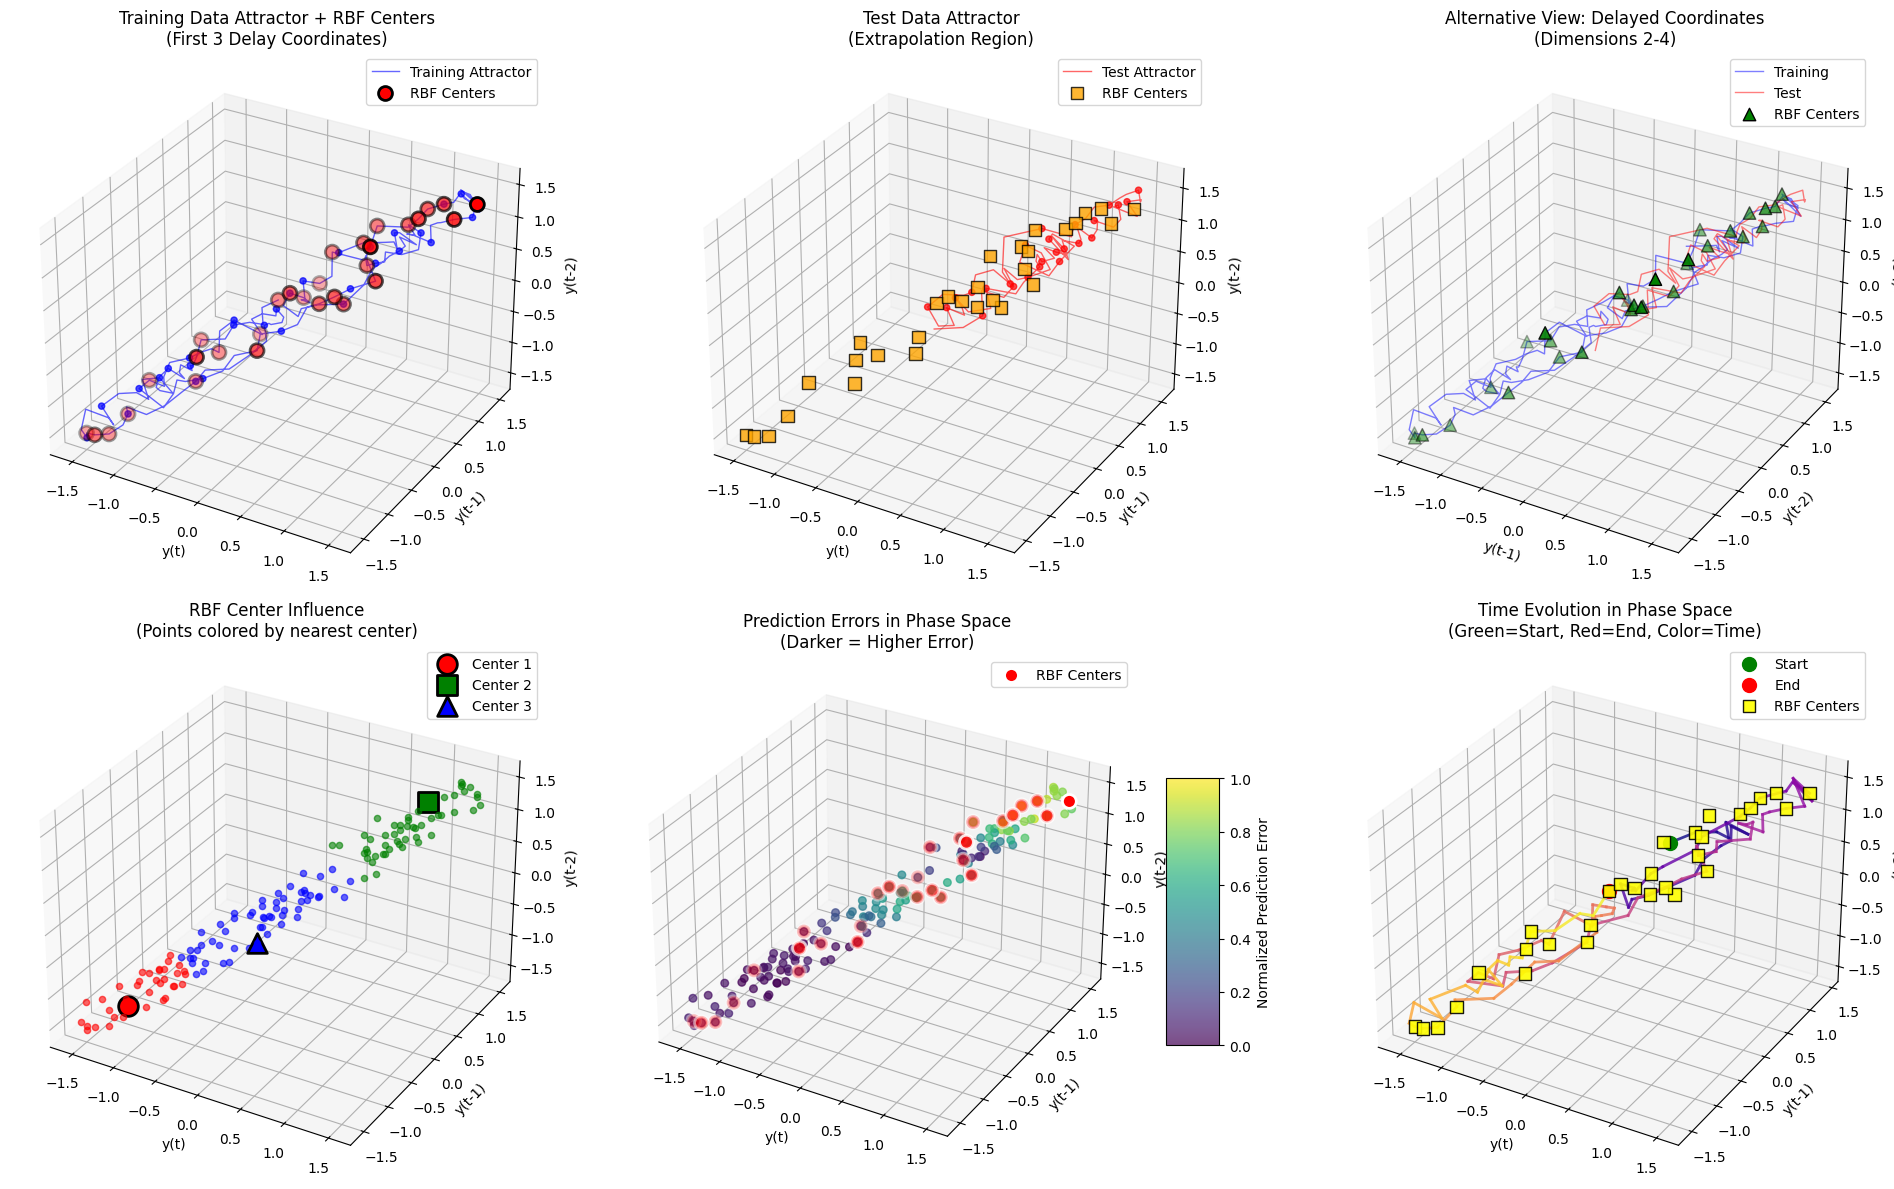


=== 3D Phase Space Analysis ===
Embedding dimension: 5
Number of RBF centers: 30
Training points in phase space: 145
Test points in phase space: 75

RBF Centers in 3D coordinates [y(t), y(t-1), y(t-2)]:
  Center 1: [-1.190, -1.181, -1.295]
  Center 2: [1.006, 1.154, 1.224]
  Center 3: [-0.131, -0.365, -0.428]
  Center 4: [-0.525, -0.465, -0.544]
  Center 5: [1.310, 1.152, 1.173]
  Center 6: [-1.295, -1.387, -1.514]
  Center 7: [-0.125, 0.057, 0.089]
  Center 8: [0.073, 0.235, 0.085]
  Center 9: [1.522, 1.241, 1.422]
  Center 10: [-1.088, -0.921, -0.896]
  Center 11: [0.978, 1.006, 1.154]
  Center 12: [0.278, 0.196, 0.091]
  Center 13: [0.167, 0.403, 0.234]
  Center 14: [-1.514, -1.473, -1.528]
  Center 15: [0.591, 0.631, 0.524]
  Center 16: [-1.387, -1.514, -1.473]
  Center 17: [-0.631, -0.730, -0.478]
  Center 18: [0.004, 0.073, 0.235]
  Center 19: [0.659, 0.572, 0.877]
  Center 20: [-0.730, -0.478, -0.417]
  Center 21: [-0.230, -0.131, -0.365]
  Center 22: [0.494, 0.321, 0.086]
  Ce

In [ ]:
# --- 3D Phase-Space Visualization ---
from mpl_toolkits.mplot3d import Axes3D

# For 3D visualization, we need at least 3 dimensions
if embedding_dim >= 3:
    fig = plt.figure(figsize=(20, 12))

    # Plot 1: Training data attractor with RBF centers
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")

    # Plot training data trajectory (attractor)
    train_x = X_train[:, 0].cpu().numpy()
    train_y = X_train[:, 1].cpu().numpy()
    train_z = X_train[:, 2].cpu().numpy()

    ax1.plot(
        train_x,
        train_y,
        train_z,
        "b-",
        alpha=0.6,
        linewidth=1,
        label="Training Attractor",
    )
    ax1.scatter(train_x[::5], train_y[::5], train_z[::5], c="blue", s=20, alpha=0.7)

    # Plot RBF centers
    if rbf_net_iterative.num_rbfs > 0:
        centers_x = [center[0].item() for center in rbf_net_iterative.centers]
        centers_y = [center[1].item() for center in rbf_net_iterative.centers]
        centers_z = [center[2].item() for center in rbf_net_iterative.centers]

        ax1.scatter(
            centers_x,
            centers_y,
            centers_z,
            c="red",
            s=100,
            marker="o",
            edgecolors="black",
            linewidth=2,
            label="RBF Centers",
        )

    ax1.set_xlabel("y(t)")
    ax1.set_ylabel("y(t-1)")
    ax1.set_zlabel("y(t-2)")
    ax1.set_title("Training Data Attractor + RBF Centers\n(First 3 Delay Coordinates)")
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Test data attractor
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")

    test_x = X_test[:, 0].cpu().numpy()
    test_y = X_test[:, 1].cpu().numpy()
    test_z = X_test[:, 2].cpu().numpy()

    ax2.plot(
        test_x, test_y, test_z, "r-", alpha=0.6, linewidth=1, label="Test Attractor"
    )
    ax2.scatter(test_x[::3], test_y[::3], test_z[::3], c="red", s=20, alpha=0.7)

    # Plot RBF centers for reference
    if rbf_net_iterative.num_rbfs > 0:
        ax2.scatter(
            centers_x,
            centers_y,
            centers_z,
            c="orange",
            s=80,
            marker="s",
            edgecolors="black",
            linewidth=1,
            label="RBF Centers",
            alpha=0.8,
        )

    ax2.set_xlabel("y(t)")
    ax2.set_ylabel("y(t-1)")
    ax2.set_zlabel("y(t-2)")
    ax2.set_title("Test Data Attractor\n(Extrapolation Region)")
    ax2.legend()
    ax2.grid(True)

    # Plot 3: Combined view with different dimensions (if available)
    if embedding_dim >= 4:
        ax3 = fig.add_subplot(2, 3, 3, projection="3d")

        # Use different delay coordinates for variety
        train_x2 = X_train[:, 1].cpu().numpy()  # y(t-1)
        train_y2 = X_train[:, 2].cpu().numpy()  # y(t-2)
        train_z2 = X_train[:, 3].cpu().numpy()  # y(t-3)

        test_x2 = X_test[:, 1].cpu().numpy()
        test_y2 = X_test[:, 2].cpu().numpy()
        test_z2 = X_test[:, 3].cpu().numpy()

        ax3.plot(
            train_x2, train_y2, train_z2, "b-", alpha=0.5, linewidth=1, label="Training"
        )
        ax3.plot(test_x2, test_y2, test_z2, "r-", alpha=0.5, linewidth=1, label="Test")

        # RBF centers in this coordinate system
        if rbf_net_iterative.num_rbfs > 0:
            centers_x2 = [center[1].item() for center in rbf_net_iterative.centers]
            centers_y2 = [center[2].item() for center in rbf_net_iterative.centers]
            centers_z2 = [center[3].item() for center in rbf_net_iterative.centers]

            ax3.scatter(
                centers_x2,
                centers_y2,
                centers_z2,
                c="green",
                s=80,
                marker="^",
                edgecolors="black",
                linewidth=1,
                label="RBF Centers",
            )

        ax3.set_xlabel("y(t-1)")
        ax3.set_ylabel("y(t-2)")
        ax3.set_zlabel("y(t-3)")
        ax3.set_title("Alternative View: Delayed Coordinates\n(Dimensions 2-4)")
        ax3.legend()
        ax3.grid(True)
    else:
        # If only 3 dimensions, show full data
        ax3 = fig.add_subplot(2, 3, 3, projection="3d")

        full_x = X_full[:, 0].cpu().numpy()
        full_y = X_full[:, 1].cpu().numpy()
        full_z = X_full[:, 2].cpu().numpy()

        # Color-code by time
        colors = plt.cm.viridis(np.linspace(0, 1, len(full_x)))
        ax3.scatter(full_x, full_y, full_z, c=colors, s=10, alpha=0.6)

        if rbf_net_iterative.num_rbfs > 0:
            ax3.scatter(
                centers_x,
                centers_y,
                centers_z,
                c="red",
                s=100,
                marker="o",
                edgecolors="black",
                linewidth=2,
                label="RBF Centers",
            )

        ax3.set_xlabel("y(t)")
        ax3.set_ylabel("y(t-1)")
        ax3.set_zlabel("y(t-2)")
        ax3.set_title("Full Time Series Attractor\n(Color = Time Progression)")
        ax3.legend()
        ax3.grid(True)

    # Plot 4: RBF activation visualization (if we have enough centers)
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")

    if rbf_net_iterative.num_rbfs >= 3:
        # Show the first 3 RBF centers and their influence
        center1 = rbf_net_iterative.centers[0].detach().cpu().numpy()
        center2 = rbf_net_iterative.centers[1].detach().cpu().numpy()
        center3 = rbf_net_iterative.centers[2].detach().cpu().numpy()

        # Plot centers
        ax4.scatter(
            center1[0],
            center1[1],
            center1[2],
            c="red",
            s=200,
            marker="o",
            edgecolors="black",
            linewidth=2,
            label="Center 1",
        )
        ax4.scatter(
            center2[0],
            center2[1],
            center2[2],
            c="green",
            s=200,
            marker="s",
            edgecolors="black",
            linewidth=2,
            label="Center 2",
        )
        ax4.scatter(
            center3[0],
            center3[1],
            center3[2],
            c="blue",
            s=200,
            marker="^",
            edgecolors="black",
            linewidth=2,
            label="Center 3",
        )

        # Plot some training points and color them by distance to nearest center
        sample_indices = np.random.choice(
            len(X_train), min(200, len(X_train)), replace=False
        )
        sample_points = X_train[sample_indices].cpu().numpy()

        # Calculate distance to nearest center for coloring
        distances_to_centers = []
        for point in sample_points:
            dist1 = np.linalg.norm(point[:3] - center1[:3])
            dist2 = np.linalg.norm(point[:3] - center2[:3])
            dist3 = np.linalg.norm(point[:3] - center3[:3])
            min_dist = min(dist1, dist2, dist3)
            if dist1 == min_dist:
                distances_to_centers.append(0)  # Closest to center 1
            elif dist2 == min_dist:
                distances_to_centers.append(1)  # Closest to center 2
            else:
                distances_to_centers.append(2)  # Closest to center 3

        colors_map = ["red", "green", "blue"]
        for i, point in enumerate(sample_points):
            ax4.scatter(
                point[0],
                point[1],
                point[2],
                c=colors_map[distances_to_centers[i]],
                s=20,
                alpha=0.6,
            )

        ax4.set_xlabel("y(t)")
        ax4.set_ylabel("y(t-1)")
        ax4.set_zlabel("y(t-2)")
        ax4.set_title("RBF Center Influence\n(Points colored by nearest center)")
        ax4.legend()
        ax4.grid(True)
    else:
        # Fallback: just show the attractor
        ax4.plot(train_x, train_y, train_z, "b-", alpha=0.6, linewidth=1)
        ax4.set_title(
            "Training Attractor\n(Insufficient RBF centers for influence plot)"
        )
        ax4.grid(True)

    # Plot 5: Prediction errors in 3D space
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")

    with torch.no_grad():
        train_errors_3d = torch.abs(train_predictions - y_train).cpu().numpy().flatten()

    # Normalize errors for color mapping
    norm_errors = (train_errors_3d - train_errors_3d.min()) / (
        train_errors_3d.max() - train_errors_3d.min() + 1e-8
    )

    scatter = ax5.scatter(
        train_x, train_y, train_z, c=norm_errors, cmap="viridis", s=30, alpha=0.7
    )

    if rbf_net_iterative.num_rbfs > 0:
        ax5.scatter(
            centers_x,
            centers_y,
            centers_z,
            c="red",
            s=100,
            marker="o",
            edgecolors="white",
            linewidth=2,
            label="RBF Centers",
        )

    ax5.set_xlabel("y(t)")
    ax5.set_ylabel("y(t-1)")
    ax5.set_zlabel("y(t-2)")
    ax5.set_title("Prediction Errors in Phase Space\n(Darker = Higher Error)")
    ax5.legend()
    ax5.grid(True)

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax5, shrink=0.5, aspect=5)
    cbar.set_label("Normalized Prediction Error")

    # Plot 6: Phase space trajectory with time evolution
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")

    # Create a trajectory that shows time evolution
    n_points = min(100, len(X_train))
    time_subset = np.linspace(0, len(X_train) - 1, n_points, dtype=int)

    for i in range(len(time_subset) - 1):
        idx = time_subset[i]
        next_idx = time_subset[i + 1]

        color_intensity = i / len(time_subset)

        ax6.plot(
            [X_train[idx, 0], X_train[next_idx, 0]],
            [X_train[idx, 1], X_train[next_idx, 1]],
            [X_train[idx, 2], X_train[next_idx, 2]],
            color=plt.cm.plasma(color_intensity),
            linewidth=2,
            alpha=0.8,
        )

    # Mark start and end points
    ax6.scatter(
        X_train[0, 0],
        X_train[0, 1],
        X_train[0, 2],
        c="green",
        s=100,
        marker="o",
        label="Start",
    )
    ax6.scatter(
        X_train[-1, 0],
        X_train[-1, 1],
        X_train[-1, 2],
        c="red",
        s=100,
        marker="o",
        label="End",
    )

    if rbf_net_iterative.num_rbfs > 0:
        ax6.scatter(
            centers_x,
            centers_y,
            centers_z,
            c="yellow",
            s=80,
            marker="s",
            edgecolors="black",
            linewidth=1,
            label="RBF Centers",
            alpha=0.9,
        )

    ax6.set_xlabel("y(t)")
    ax6.set_ylabel("y(t-1)")
    ax6.set_zlabel("y(t-2)")
    ax6.set_title("Time Evolution in Phase Space\n(Green=Start, Red=End, Color=Time)")
    ax6.legend()
    ax6.grid(True)

    plt.tight_layout()
    plt.show()

    # Additional information
    print(f"\n=== 3D Phase Space Analysis ===")
    print(f"Embedding dimension: {embedding_dim}")
    print(f"Number of RBF centers: {rbf_net_iterative.num_rbfs}")
    print(f"Training points in phase space: {len(X_train)}")
    print(f"Test points in phase space: {len(X_test)}")

    if rbf_net_iterative.num_rbfs > 0:
        print(f"\nRBF Centers in 3D coordinates [y(t), y(t-1), y(t-2)]:")
        for i, center in enumerate(rbf_net_iterative.centers):
            center_3d = center[:3].detach().cpu().numpy()
            print(
                f"  Center {i+1}: [{center_3d[0]:.3f}, {center_3d[1]:.3f}, {center_3d[2]:.3f}]"
            )

    # Calculate some phase space statistics
    train_centroid = torch.mean(X_train[:, :3], dim=0)
    print(
        f"\nPhase space centroid (training): [{train_centroid[0]:.3f}, {train_centroid[1]:.3f}, {train_centroid[2]:.3f}]"
    )

    # Calculate the "size" of the attractor
    train_std = torch.std(X_train[:, :3], dim=0)
    print(
        f"Phase space spread (std): [{train_std[0]:.3f}, {train_std[1]:.3f}, {train_std[2]:.3f}]"
    )

else:
    print(
        f"Cannot create 3D phase space plots: embedding dimension is {embedding_dim} (need >= 3)"
    )
    print(
        "Increase embedding_dim to at least 3 to visualize the phase space attractor."
    )


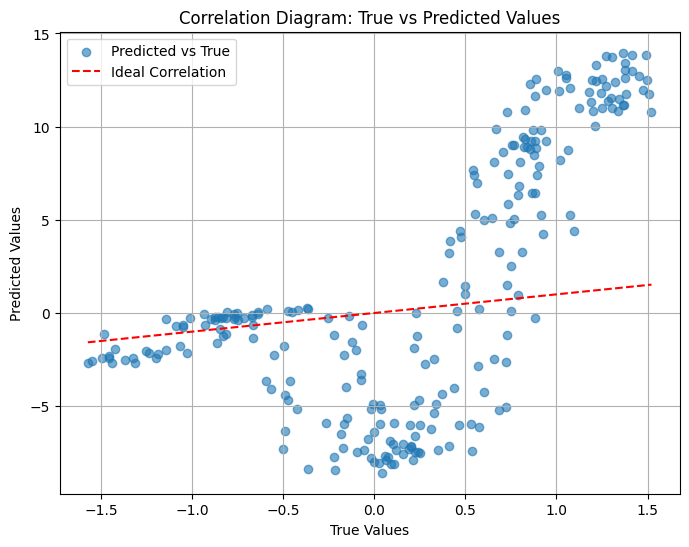

In [ ]:
y_true = y_full.cpu().numpy().flatten()
y_pred = full_predictions.cpu().numpy().flatten()

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.6, label="Predicted vs True")
plt.plot(
    [y_true.min(), y_true.max()],
    [y_true.min(), y_true.max()],
    "r--",
    label="Ideal Correlation",
)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Correlation Diagram: True vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()
